In [1]:
import pandas as pd
from sklearn.ensemble import IsolationForest


In [2]:
# Load your dataset (if not already in a DataFrame)
df = pd.read_csv("./Count_Statistics_2022_Trimmed_CSV.csv")

df_filtered = df[["REGION", "COUNTY_FIPS", "COUNT_STATS_ID", "AADT"]].dropna()

# scale the data
import numpy as np

# scaler = StandardScaler()
# df_filtered["AADT_zscore"] = scaler.fit_transform(df_filtered[["AADT"]])
# iso_forest = IsolationForest(contamination=0.05, random_state=42, n_estimators=100)
# df_filtered["Anomaly"] = iso_forest.fit_predict(df_filtered[["AADT_zscore"]])

df_filtered["AADT_log"] = np.log1p(df["AADT"])  # log(1 + AADT) avoids log(0)

# Now apply StandardScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_filtered[["AADT_log"]])

In [3]:
# Initialize Isolation Forest
iso_forest = IsolationForest(contamination=0.01, random_state=42, n_estimators=100)
df_filtered["Anomaly"] = iso_forest.fit_predict(df_scaled)


In [4]:
# Count anomalies vs normal points
print(df_filtered["Anomaly"].value_counts())

anomalies = df_filtered[df_filtered["Anomaly"] == -1]
print(anomalies)


Anomaly
 1    146747
-1      1482
Name: count, dtype: int64
        REGION  COUNTY_FIPS  COUNT_STATS_ID  AADT  AADT_log  Anomaly
91         7.0         89.0        48158089   0.0  0.000000       -1
92         7.0         89.0        48158090   0.0  0.000000       -1
777        9.0         25.0        48159967   2.0  1.098612       -1
785        9.0         25.0        48160275   4.0  1.609438       -1
786        9.0         25.0        48160276   4.0  1.609438       -1
...        ...          ...             ...   ...       ...      ...
148551     2.0         53.0        48306078   3.0  1.386294       -1
148611     9.0         77.0        48307116   1.0  0.693147       -1
148708     2.0         65.0        48304723   3.0  1.386294       -1
148866     9.0         95.0        48307148   1.0  0.693147       -1
148867     9.0         95.0        48307149   1.0  0.693147       -1

[1482 rows x 6 columns]


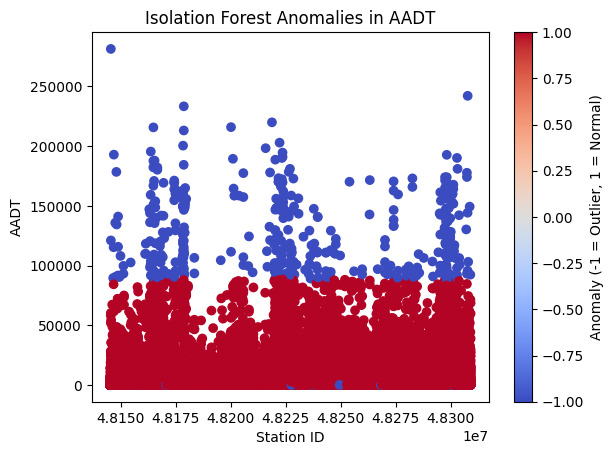

In [5]:
import matplotlib.pyplot as plt

plt.scatter(df_filtered["COUNT_STATS_ID"], df_filtered["AADT"], c=df_filtered["Anomaly"], cmap="coolwarm")
plt.xlabel("Station ID")
plt.ylabel("AADT")
plt.title("Isolation Forest Anomalies in AADT")
plt.colorbar(label="Anomaly (-1 = Outlier, 1 = Normal)")
plt.show()



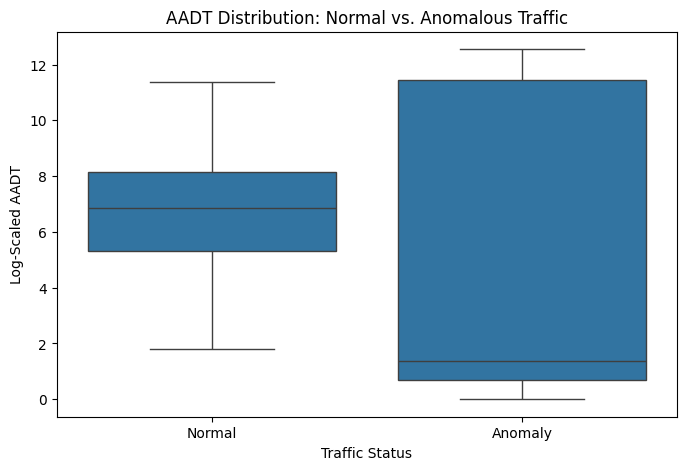

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.boxplot(x=df_filtered["Anomaly"].map({1: "Normal", -1: "Anomaly"}), y=df_filtered["AADT_log"])
plt.xlabel("Traffic Status")
plt.ylabel("Log-Scaled AADT")
plt.title("AADT Distribution: Normal vs. Anomalous Traffic")
plt.show()



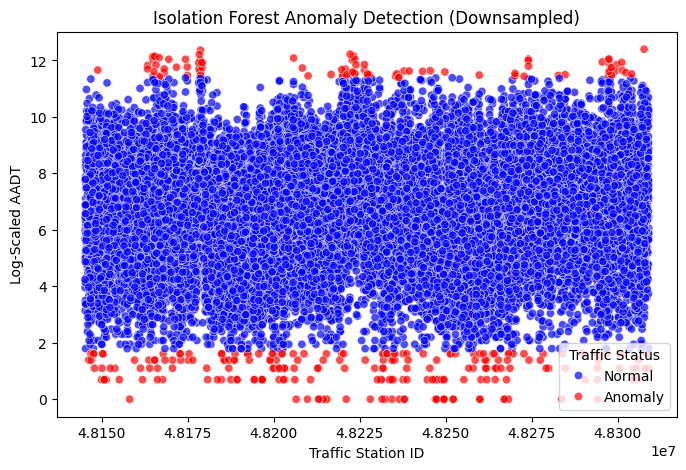

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

df_sample = df_filtered.sample(frac=0.2, random_state=42)  # Take 20% of the data

plt.figure(figsize=(8, 5))
sns.scatterplot(
    x=df_sample["COUNT_STATS_ID"], 
    y=df_sample["AADT_log"], 
    hue=df_sample["Anomaly"].map({1: "Normal", -1: "Anomaly"}), 
    palette={"Normal": "blue", "Anomaly": "red"},
    alpha=0.7
)
plt.xlabel("Traffic Station ID")
plt.ylabel("Log-Scaled AADT")
plt.title("Isolation Forest Anomaly Detection (Downsampled)")
plt.legend(title="Traffic Status")
plt.show()



In [14]:
df_filtered[["REGION", "COUNTY_FIPS", "COUNT_STATS_ID", "AADT", "Anomaly"]].to_csv("iforest_results.csv", index=False)
